<a href="https://colab.research.google.com/github/cuong3004/Trash_Cuong/blob/main/trash_yolov5_orginal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt  # install dependencies

import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.11.0+cu113 (Tesla T4)


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !cp /content/yolov5/tensorflow-1.14.0-cp37-none-linux_armv7l.whl /content/drive/MyDrive

In [ ]:
# !pip install wandb
# import wandb
# wandb.login()

     |████████████████████████████████| 1.8 MB 5.1 MB/s 
     |████████████████████████████████| 144 kB 49.1 MB/s 
     |████████████████████████████████| 181 kB 43.4 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=d30227fb4cb1fd4b688cd1722ae7e09c2ab82568f2a5c4cd04ec80dd33720391
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
!rm -rf ../datasets

In [ ]:
!curl -L "https://app.roboflow.com/ds/4TgxV5OKnf?key=V1XP37RPd4" > roboflow.zip; unzip roboflow.zip -d "../datasets"; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   896  100   896    0     0   1659      0 --:--:-- --:--:-- --:--:--  1656
100  417k  100  417k    0     0   572k      0 --:--:-- --:--:-- --:--:--  572k
Archive:  roboflow.zip
 extracting: ../datasets/README.dataset.txt  
 extracting: ../datasets/README.roboflow.txt  
 extracting: ../datasets/data.yaml   
   creating: ../datasets/test/
   creating: ../datasets/test/images/
 extracting: ../datasets/test/images/image_55_png.rf.b98e602d83d71752fd18043d86c2269a.jpg  
   creating: ../datasets/test/labels/
 extracting: ../datasets/test/labels/image_55_png.rf.b98e602d83d71752fd18043d86c2269a.txt  
   creating: ../datasets/train/
   creating: ../datasets/train/images/
 extracting: ../datasets/train/images/image_10_png.rf.0382c6c7f359385aae17c1f90fdec1bf.jpg  
 extracting: ../datasets/train/images/image_10_png.rf.ae94be647f9276193657b

In [ ]:
%%writefile ./data/datatraffic.yaml


train: ../datasets/train/images
val: ../datasets/valid/images

nc: 2
names: ['nylon', 'paper']

Writing ./data/datatraffic.yaml


In [ ]:
%%writefile my_yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 2  # number of classes
depth_multiple: 0.2  # model depth multiple
width_multiple: 0.3  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

Overwriting my_yolov5s.yaml


In [ ]:
# ! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

# ! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

# ! sudo apt-get update

# ! sudo apt-get install edgetpu-compiler	

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  66763      0 --:--:-- --:--:-- --:--:-- 66763
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:2 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6,722 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:9 http://archive.ubun

In [ ]:
!edgetpu_compiler /content/best-int8.tflite

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.
ERROR: Restored original execution plan after delegate application failure.
Compilation failed: Compilation failed due to large activation tensors in model.
Compilation child process completed within timeout period.
Compilation failed! 


In [ ]:
!rm -rf /content/best-*

In [ ]:
!python export.py --weights /content/yolov5/runs/train/exp2/weights/best.pt --include edgetpu --imgsz 320

export: data=data/coco128.yaml, weights=['/content/yolov5/runs/train/exp2/weights/best.pt'], imgsz=[320], batch_size=1, device=cpu, half=False, inplace=False, train=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['edgetpu']
YOLOv5 🚀 v6.1-176-gaa7a0e9 torch 1.11.0+cu113 CPU

Fusing layers... 
my_YOLOv5s summary: 224 layers, 4673663 parameters, 0 gradients, 11.4 GFLOPs

PyTorch: starting from /content/yolov5/runs/train/exp2/weights/best.pt with output shape (1, 6300, 7) (9.2 MB)
requirements: flatbuffers==1.12 not found and is required by YOLOv5, attempting auto-update...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not ins

In [ ]:
import tensorflow as tf

interpreter = tf.lite.Interpreter('/content/best-fp16.tflite')
interpreter.allocate_tensors()

ValueError: ignored

In [ ]:
!python detect.py --weight /content/best-int8.tflite --source /content/datasets/test/images/IMG_0002_jpg.rf.8981aa4cdb82b5a12834ed2fba4f91d6.jpg  --imgsz 320

detect: weights=['/content/best-int8.tflite'], source=/content/datasets/test/images/IMG_0002_jpg.rf.8981aa4cdb82b5a12834ed2fba4f91d6.jpg, data=data/coco128.yaml, imgsz=[320, 320], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-174-gc4cb7c6 torch 1.11.0+cu113 CPU

Loading /content/best-int8.tflite for TensorFlow Lite inference...
[tensor([[ 61.13942, 173.22836, 115.48558, 247.95435,   0.97435,   3.00000],
        [139.26204, 125.67549, 180.02165, 173.22838,   0.96376,   0.00000],
        [157.94353,  78.12260, 202.09978, 132.46875,   0.95317,   3.00000],
        [ 44.15625, 113.78727,  98.50241, 185.11661,   0.95317,   2.00000],
        [130.77042, 185.11658, 208.89304, 263.23920,   0.9

In [ ]:
import numpy as np
from PIL import Image


In [ ]:
!pip list

In [ ]:
input_details

{'dtype': numpy.uint8,
 'index': 0,
 'name': 'serving_default_input_1:0',
 'quantization': (0.003921568859368563, 0),
 'quantization_parameters': {'quantized_dimension': 0,
  'scales': array([0.00392157], dtype=float32),
  'zero_points': array([0], dtype=int32)},
 'shape': array([  1, 320, 320,   3], dtype=int32),
 'shape_signature': array([  1, 320, 320,   3], dtype=int32),
 'sparsity_parameters': {}}

In [ ]:
import torch 

prediction = torch.rand(1,6300,9)

In [ ]:
prediction[..., 4].shape

torch.Size([1, 6300])

In [ ]:
import time
import torch
import torchvision

def box_area(box):
    # box = xyxy(4,n)
    return (box[2] - box[0]) * (box[3] - box[1])


def box_iou(box1, box2):
    # https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py
    """
    Return intersection-over-union (Jaccard index) of boxes.
    Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
    Arguments:
        box1 (Tensor[N, 4])
        box2 (Tensor[M, 4])
    Returns:
        iou (Tensor[N, M]): the NxM matrix containing the pairwise
            IoU values for every element in boxes1 and boxes2
    """

    # inter(N,M) = (rb(N,M,2) - lt(N,M,2)).clamp(0).prod(2)
    (a1, a2), (b1, b2) = box1[:, None].chunk(2, 2), box2.chunk(2, 1)
    inter = (torch.min(a2, b2) - torch.max(a1, b1)).clamp(0).prod(2)

    # IoU = inter / (area1 + area2 - inter)
    return inter / (box_area(box1.T)[:, None] + box_area(box2.T) - inter)

def xywh2xyxy(x):
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
    y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
    y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
    y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
    return y

def non_max_suppression(prediction,
                        conf_thres=0.25,
                        iou_thres=0.45,
                        classes=None,
                        agnostic=False,
                        multi_label=False,
                        labels=(),
                        max_det=300):
    """Non-Maximum Suppression (NMS) on inference results to reject overlapping bounding boxes

    Returns:
         list of detections, on (n,6) tensor per image [xyxy, conf, cls]
    """

    bs = prediction.shape[0]  # batch size
    nc = prediction.shape[2] - 5  # number of classes
    xc = prediction[..., 4] > conf_thres  # candidates

    # Checks
    assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
    assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'

    # Settings
    # min_wh = 2  # (pixels) minimum box width and height
    max_wh = 7680  # (pixels) maximum box width and height
    max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
    time_limit = 0.1 + 0.03 * bs  # seconds to quit after
    redundant = True  # require redundant detections
    multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
    merge = False  # use merge-NMS

    t = time.time()
    output = [torch.zeros((0, 6))] * bs
    for xi, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
        x = x[xc[xi]]  # confidence

        # Cat apriori labels if autolabelling
        if labels and len(labels[xi]):
            lb = labels[xi]
            v = torch.zeros((len(lb), nc + 5), device=x.device)
            v[:, :4] = lb[:, 1:5]  # box
            v[:, 4] = 1.0  # conf
            v[range(len(lb)), lb[:, 0].long() + 5] = 1.0  # cls
            x = torch.cat((x, v), 0)

        # If none remain process next image
        if not x.shape[0]:
            continue

        # Compute conf
        x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

        # Box (center x, center y, width, height) to (x1, y1, x2, y2)
        box = xywh2xyxy(x[:, :4])

        # Detections matrix nx6 (xyxy, conf, cls)
        if multi_label:
            i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
            x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
        else:  # best class only
            conf, j = x[:, 5:].max(1, keepdim=True)
            x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]

        # Filter by class
        if classes is not None:
            x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

        # Apply finite constraint
        # if not torch.isfinite(x).all():
        #     x = x[torch.isfinite(x).all(1)]

        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        elif n > max_nms:  # excess boxes
            x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence

        # Batched NMS
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
        boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
        i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
        if i.shape[0] > max_det:  # limit detections
            i = i[:max_det]
        if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
            # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
            iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
            weights = iou * scores[None]  # box weights
            x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
            if redundant:
                i = i[iou.sum(1) > 1]  # require redundancy

        output[xi] = x[i]
        if (time.time() - t) > time_limit:
            LOGGER.warning(f'WARNING: NMS time limit {time_limit:.3f}s exceeded')
            break  # time limit exceeded

    return output

In [ ]:
import torch 

In [ ]:
interpreter = tf.lite.Interpreter('/content/yolov5/runs/train/exp2/weights/best-int8.tflite')
interpreter.allocate_tensors()

In [ ]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()



In [ ]:
scale, zero_point = input_details[0]['quantization']


In [ ]:
import numpy as np
from PIL import Image
img_orgin = np.asarray(Image.open("/content/datasets/valid/images/503_png.rf.86318ad8a538281b3fd84a520c1433a0.jpg"))

# img /= 255 
img = np.uint8((img_orgin[None] /255) / scale + zero_point)
# img = img / 255

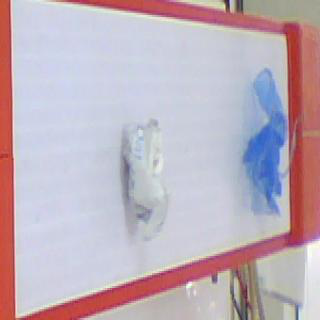

In [ ]:
Image.open("/content/datasets/valid/images/503_png.rf.86318ad8a538281b3fd84a520c1433a0.jpg")

In [ ]:

# np.uint8((img[None] /255) / scale + )

In [ ]:
interpreter.set_tensor(input_details[0]['index'], img)
interpreter.invoke()

In [ ]:
output_data = interpreter.get_tensor(output_details[0]['index'])
scale, zero_point = output_details[0]['quantization']
output_data = (output_data.astype(np.float32) - zero_point) * scale
print(output_data.shape)

(1, 6300, 7)


In [ ]:
def classFilter(classdata):
    classes = []  # create a list
    for i in range(classdata.shape[0]):         # loop through all predictions
        classes.append(classdata[i].argmax())   # get the best classification location
    return classes  # return classes (int)

def YOLOdetect(output_data):  # input = interpreter, output is boxes(xyxy), classes, scores
    output_data = output_data[0]                # x(1, 25200, 7) to x(25200, 7)
    boxes = np.squeeze(output_data[..., :4])    # boxes  [25200, 4]
    scores = np.squeeze( output_data[..., 4:5]) # confidences  [25200, 1]
    classes = classFilter(output_data[..., 5:]) # get classes
    x, y, w, h = boxes[..., 0], boxes[..., 1], boxes[..., 2], boxes[..., 3] #xywh
    xyxy = [x - w / 2, y - h / 2, x + w / 2, y + h / 2]  # xywh to xyxy   [4, 25200]

    return xyxy, classes, scores  # output is boxes(x,y,x,y), classes(int), scores(float) [predictions length]

In [ ]:
xyxy, classes, scores = YOLOdetect(output_data)

In [ ]:
len(xyxy), len(classes), len(scores) 

(4, 6300, 6300)

In [ ]:
# scores.

In [ ]:
boxes = np.stack(xyxy, -1)
# boxes.shape

In [ ]:
non_max_suppression(torch.from_numpy(output_data))

NameError: ignored

In [ ]:
[tensor([[ 61.13942, 173.22836, 115.48558, 247.95435,   0.97435,   3.00000],
        [139.26204, 125.67549, 180.02165, 173.22838,   0.96376,   0.00000],
        [157.94353,  78.12260, 202.09978, 132.46875,   0.95317,   3.00000],
        [ 44.15625, 113.78727,  98.50241, 185.11661,   0.95317,   2.00000],
        [130.77042, 185.11658, 208.89304, 263.23920,   0.94302,   2.00000],
        [ 96.80409,  50.94952, 147.75362, 118.88221,   0.92274,   2.00000]])]

In [ ]:
import cv2
for i in range(len(scores)):
    if ((scores[i] > 0.1) and (scores[i] <= 1.0)):
        H = img_orgin.shape[0]
        W = img_orgin.shape[1]
        xmin = int(max(1,(xyxy[0][i] * W)))
        ymin = int(max(1,(xyxy[1][i] * H)))
        xmax = int(min(H,(xyxy[2][i] * W)))
        ymax = int(min(W,(xyxy[3][i] * H)))

        cv2.rectangle(img_orgin, (xmin,ymin), (xmax,ymax), (10, 255, 0), 2)

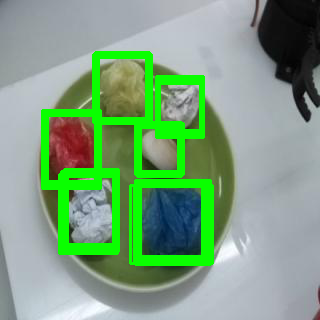

In [ ]:
Image.fromarray(img_orgin)

In [ ]:
import tensorflow as tf

In [ ]:
selected_indices = tf.image.non_max_suppression(
      boxes, scores, 50, 0.5)

In [ ]:
selected_indices.shape

TensorShape([100])

In [ ]:
def classFilter(classdata):

    # print(classdata.shape)
    # classes = []  # create a list
    # for i in range(classdata.shape[0]):         # loop through all predictions
    #     classes.append(classdata[i].argmax())   # get the best classification location
    # return classes  # return classes (int)
    print(classdata)
    print(tf.math.argmax(classdata, -1))
    return tf.math.argmax(classdata, -1)

def YOLOdetect(output_data):  # input = interpreter, output is boxes(xyxy), classes, scores
    output_data = output_data[0]                # x(1, 25200, 7) to x(25200, 7)
    # print(output_data[..., :4].shape)
    boxes = tf.squeeze(output_data[..., :4])  # boxes  [25200, 4]
    # print(boxes.shape)
    scores = tf.squeeze(output_data[..., 4:5]) # confidences  [25200, 1]
    classes = classFilter(output_data[..., 5:]) # get classes
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    x, y, w, h = boxes[..., 0], boxes[..., 1], boxes[..., 2], boxes[..., 3] #xywh
    xyxy = [x - w / 2, y - h / 2, x + w / 2, y + h / 2]  # xywh to xyxy   [4, 25200]

    return xyxy, classes, scores  # output is boxes(x,y,x,y), classes(int), scores(float) [predictions length]

In [ ]:
import tensorflow as tf

In [ ]:
class NMS(tf.Module):
    @tf.function(input_signature=[tf.TensorSpec(shape=[1, 6300, 7], dtype=tf.float32)])
    def __call__(self, out):
        # print(out.shape)
        xyxy, classes, scores = self.YOLOdetect(out)

        boxes = tf.stack(xyxy, -1)

        # print(classes)
        selected_indices = tf.image.non_max_suppression(
            boxes, scores, 50, 0.5)
        
        # ptin
        
        selected_boxes = tf.gather(boxes, selected_indices)
        selected_scores = tf.gather(scores, selected_indices)
        selected_classes = tf.gather(classes, selected_indices)

        return selected_boxes, selected_scores, selected_classes
    
    def classFilter(self, classdata):

        # print(classdata.shape)
        # classes = []  # create a list
        # for i in range(classdata.shape[0]):         # loop through all predictions
        #     classes.append(classdata[i].argmax())   # get the best classification location
        # # return classes  # return classes (int)
        # print(classdata)
        # print(tf.math.argmax(classdata, -1))
        return tf.math.argmax(classdata, -1)
    
    
    def YOLOdetect(self, output_data):  # input = interpreter, output is boxes(xyxy), classes, scores
        output_data = output_data[0]                # x(1, 25200, 7) to x(25200, 7)
        # print(output_data[..., :4].shape)
        boxes = tf.squeeze(output_data[..., :4])  # boxes  [25200, 4]
        # print(boxes.shape)
        scores = tf.squeeze(output_data[..., 4:5]) # confidences  [25200, 1]
        # print(output_data[..., 5:])
        classes = self.classFilter(output_data[..., 5:]) # get classes
        # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
        x, y, w, h = boxes[..., 0], boxes[..., 1], boxes[..., 2], boxes[..., 3] #xywh
        xyxy = [x - w / 2, y - h / 2, x + w / 2, y + h / 2]  # xywh to xyxy   [4, 25200]

        return xyxy, classes, scores  # output is boxes(x,y,x,y), classes(int), scores(float) [pr


In [ ]:
nms(output_data)

(<tf.Tensor: shape=(50, 4), dtype=float32, numpy=
 array([[ 0.3817913 ,  0.35822397,  0.5420494 ,  0.7353018 ],
        [ 0.7494422 ,  0.20739281,  0.9097003 ,  0.697594  ],
        [ 0.6504593 ,  0.23096016,  1.0275371 ,  0.6551727 ],
        [ 0.35351047,  0.2733814 ,  0.53262246,  0.6316054 ],
        [ 0.78243655,  0.15083113,  0.91441375,  0.5467628 ],
        [-0.01885389, -0.00942695,  0.05656167,  0.04713473],
        [-0.01885389, -0.00471347,  0.13197725,  0.04242126],
        [ 0.04242126, -0.00471347,  0.22153324,  0.04242126],
        [ 0.08012904,  0.00471347,  0.24038713,  0.03299431],
        [ 0.5090551 , -0.00471347,  0.7164479 ,  0.04242126],
        [ 0.72116137,  0.        ,  0.8625655 ,  0.03770778],
        [ 0.876706  ,  0.        ,  1.0086832 ,  0.03770778],
        [ 0.9332676 , -0.00942695,  0.9898293 ,  0.02828084],
        [ 0.00942694, -0.01414042,  0.08484251,  0.07070209],
        [-0.01414042, -0.01414042,  0.14611766,  0.08955599],
        [ 0.8955599 

In [ ]:
nms = NMS()
concrete_func = nms.__call__.get_concrete_function()

(None, 4)


In [ ]:
# nms.build([1,6300,4])

In [ ]:
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func],
                                                            nms)
tflite_model = converter.convert()

# Save the model.
with open('nms.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpvrklvvg3/assets


In [ ]:
interpreter = tf.lite.Interpreter("/content/yolov5/model.tflite"
)
interpreter.allocate_tensors()

In [ ]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()



In [ ]:
interpreter.set_tensor(input_details[0]['index'], output_data)
interpreter.invoke()

In [ ]:
output_bboxes = interpreter.get_tensor(output_details[1]['index'])
output_scores = interpreter.get_tensor(output_details[0]['index'])
output_classes = interpreter.get_tensor(output_details[2]['index'])
# scale, zero_point = output_details[0]['quantization']
# output_data = (output_data.astype(np.float32) - zero_point) * scale
# print(output_data.shape)

In [ ]:
output_scores

array([0.9765325 , 0.965918  , 0.965918  , 0.965918  , 0.965918  ,
       0.95530355, 0.0636869 , 0.02122897, 0.01061448, 0.01061448,
       0.01061448, 0.01061448, 0.01061448, 0.01061448, 0.01061448,
       0.01061448, 0.01061448, 0.01061448, 0.01061448, 0.01061448,
       0.01061448, 0.01061448, 0.01061448, 0.01061448, 0.01061448,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)

In [ ]:
output_bboxes.shape

(50, 4)

In [ ]:
nms(output_data)

(<tf.Tensor: shape=(50, 4), dtype=float32, numpy=
 array([[ 0.19106069,  0.5413387 ,  0.36089244,  0.7748573 ],
        [ 0.14329553,  0.35558522,  0.3025128 ,  0.57848936],
        [ 0.49357352,  0.24413311,  0.6315618 ,  0.41396487],
        [ 0.43519384,  0.3927359 ,  0.56256765,  0.5413387 ],
        [ 0.2918983 ,  0.16983172,  0.47234452,  0.3821214 ],
        [ 0.4086576 ,  0.57848936,  0.6527907 ,  0.8226225 ],
        [ 0.67932695,  0.7058631 ,  0.9977614 ,  1.0136832 ],
        [ 0.34497073,  0.5094952 ,  0.73770666,  0.8491587 ],
        [ 0.95530355,  0.83854425,  0.9977615 ,  0.987147  ],
        [ 0.97122526,  0.8810021 ,  1.0030687 ,  1.0083759 ],
        [ 0.9606108 ,  0.8969239 ,  0.99245423,  1.0136832 ],
        [ 0.9499963 ,  0.9287673 ,  1.0030687 ,  1.0242977 ],
        [ 0.76955   ,  0.10614484,  0.8650804 ,  0.29720554],
        [ 0.812008  ,  0.61564004,  1.0136832 ,  1.0402194 ],
        [ 0.90223116,  0.6687125 ,  1.008376  ,  0.987147  ],
        [ 0.5731821 

In [ ]:
!edgetpu_compiler model.tflite

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 1 ms.

Input model: model.tflite
Input size: 4.79KiB
Output model: model_edgetpu.tflite
Output size: 3.90KiB
On-chip memory used for caching model parameters: 0.00B
On-chip memory remaining for caching model parameters: 0.00B
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 0
Total number of operations: 21
Operation log: model_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 0
Number of operations that will run on CPU: 21
See the operation log file for individual operation details.
Compilation child process completed wit

In [ ]:
scores.shape

(6300,)

In [ ]:
!wget https://www.piwheels.org/simple/tensorflow/tensorflow-1.14.0-cp37-none-linux_armv7l.whl 

--2022-05-06 09:28:13--  https://www.piwheels.org/simple/tensorflow/tensorflow-1.14.0-cp37-none-linux_armv7l.whl
Resolving www.piwheels.org (www.piwheels.org)... 93.93.129.174, 46.235.225.189, 2a00:1098:0:82:1000:3b:1:1, ...
Connecting to www.piwheels.org (www.piwheels.org)|93.93.129.174|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79571696 (76M)
Saving to: ‘tensorflow-1.14.0-cp37-none-linux_armv7l.whl’

tensorflow-1.14.0-c 100%[===================>]  75.88M  17.2MB/s    in 4.2s    

2022-05-06 09:28:17 (18.0 MB/s) - ‘tensorflow-1.14.0-cp37-none-linux_armv7l.whl’ saved [79571696/79571696]



In [ ]:
selected_scores = tf.gather(scores, selected_indices)

In [ ]:
selected_scores.to

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([0.9765325 , 0.965918  , 0.965918  , 0.965918  , 0.965918  ,
       0.95530355, 0.0636869 , 0.02122897, 0.01061448, 0.01061448,
       0.01061448, 0.01061448, 0.01061448, 0.01061448, 0.01061448,
       0.01061448, 0.01061448, 0.01061448, 0.01061448, 0.01061448,
       0.01061448, 0.01061448, 0.01061448, 0.01061448, 0.01061448,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [ ]:
selected_boxes

<tf.Tensor: shape=(100, 4), dtype=float32, numpy=
array([[ 0.19106069,  0.5413387 ,  0.36089244,  0.7748573 ],
       [ 0.14329553,  0.35558522,  0.3025128 ,  0.57848936],
       [ 0.49357352,  0.24413311,  0.6315618 ,  0.41396487],
       [ 0.43519384,  0.3927359 ,  0.56256765,  0.5413387 ],
       [ 0.2918983 ,  0.16983172,  0.47234452,  0.3821214 ],
       [ 0.4086576 ,  0.57848936,  0.6527907 ,  0.8226225 ],
       [ 0.67932695,  0.7058631 ,  0.9977614 ,  1.0136832 ],
       [ 0.34497073,  0.5094952 ,  0.73770666,  0.8491587 ],
       [ 0.95530355,  0.83854425,  0.9977615 ,  0.987147  ],
       [ 0.97122526,  0.8810021 ,  1.0030687 ,  1.0083759 ],
       [ 0.9606108 ,  0.8969239 ,  0.99245423,  1.0136832 ],
       [ 0.9499963 ,  0.9287673 ,  1.0030687 ,  1.0242977 ],
       [ 0.76955   ,  0.10614484,  0.8650804 ,  0.29720554],
       [ 0.812008  ,  0.61564004,  1.0136832 ,  1.0402194 ],
       [ 0.90223116,  0.6687125 ,  1.008376  ,  0.987147  ],
       [ 0.5731821 ,  0.8173153 ,  

In [ ]:
# Train YOLOv5s on COCO128 for 3 epochs
!python train.py --img 100 --batch 32 --epochs 100 --data ./data/datatraffic.yaml --cfg my_yolov5s.yaml --weights ""

train: weights=, cfg=my_yolov5s.yaml, data=./data/datatraffic.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=32, imgsz=100, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-178-g4870064 torch 1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degr